# Using Barrier Statement on Amazon Braket

In [ ]:
# Use Braket SDK Cost Tracking to estimate the cost to run this example
from braket.tracking import Tracker

t = Tracker().start()

## Overview

The `barrier` statement in OpenQASM 3 is a compiler directive that prevents circuit optimization across the barrier boundary. This is particularly useful when you want to preserve the structure of your quantum circuit and prevent the compiler from reordering or merging gates in ways that might change the intended behavior or timing of your algorithm.

Amazon Braket now supports the `barrier` statement on Rigetti and IQM quantum processing units (QPUs). In this notebook, we demonstrate:

- What the barrier statement does and when to use it
- How to use barriers in OpenQASM programs on Braket
- How to use barriers with the Braket SDK Circuit class
- Examples of running circuits with barriers on Rigetti and IQM devices

### What you'll learn:
- The purpose and behavior of the barrier statement
- How to insert barriers in quantum circuits
- When barriers are useful for preserving circuit structure
- How to run barrier-enabled circuits on real quantum hardware

## Understanding the Barrier Statement

### What is a barrier?

A `barrier` is a compiler directive that acts as a fence in your quantum circuit. Gates before the barrier cannot be moved or optimized past the barrier, and gates after the barrier cannot be moved before it. This ensures that:

1. **Circuit structure is preserved**: The logical separation you intend is maintained
2. **Optimization is controlled**: The compiler can still optimize within barrier-separated regions
3. **Timing is respected**: Useful for algorithms where gate timing matters

### When to use barriers

Barriers are useful in several scenarios:

- **Debugging**: Preserve circuit structure to understand behavior
- **Benchmarking**: Ensure specific gate sequences are executed as written
- **Algorithm structure**: Maintain logical phases of an algorithm (e.g., initialization, computation, measurement)
- **Preventing unwanted optimization**: When compiler optimization might change intended behavior

In [2]:
# Import necessary modules
import matplotlib.pyplot as plt

from braket.aws import AwsDevice
from braket.circuits import Circuit
from braket.circuits.serialization import IRType

## Example 1: Using Barriers with the Braket SDK

Let's start with a simple example showing how to use the barrier statement using the Braket SDK.

In [3]:
# Create a circuit with barriers using the SDK
circuit_with_barriers = Circuit()

# Initialization
circuit_with_barriers.h(0)
circuit_with_barriers.h(1)

# Add barrier across all qubits
circuit_with_barriers.barrier([0, 1])

# Apply rotations
circuit_with_barriers.rx(0, 0.5)
circuit_with_barriers.ry(1, 0.3)

# Another barrier
circuit_with_barriers.barrier([0, 1])

# Entanglement
circuit_with_barriers.cnot(0, 1)

# Final barrier before measurement
circuit_with_barriers.barrier([0, 1])

print(circuit_with_barriers)

T  : │  0  │  1   │     2      │  3   │  4  │  5   │
      ┌───┐        ┌──────────┐                     
q0 : ─┤ H ├───▒────┤ Rx(0.50) ├───▒──────●─────▒────
      └───┘        └──────────┘          │          
      ┌───┐        ┌──────────┐        ┌─┴─┐        
q1 : ─┤ H ├───▒────┤ Ry(0.30) ├───▒────┤ X ├───▒────
      └───┘        └──────────┘        └───┘        
T  : │  0  │  1   │     2      │  3   │  4  │  5   │


## Example 2: Basic Barrier Usage in OpenQASM

Now let's look at how to use the barrier statement in OpenQASM. We'll create a Bell state with barriers separating different logical phases of the circuit.

In [4]:
# Bell state with barriers
bell_with_barrier_qasm = """
OPENQASM 3;

qubit[2] q;
bit[2] c;

// Initialization phase
h q[0];

// Barrier prevents optimization across this boundary
barrier q;

// Entanglement phase
cnot q[0], q[1];

// Another barrier before measurement
barrier q;

// Measurement phase
c = measure q;
"""

### Convert to Braket Circuit

We can convert this OpenQASM program to a Braket Circuit to visualize it:

In [5]:
bell_circuit = Circuit().from_ir(source=bell_with_barrier_qasm)
print(bell_circuit)

T  : │  0  │  1   │  2  │  3   │  4  │
      ┌───┐                     ┌───┐ 
q0 : ─┤ H ├───▒──────●─────▒────┤ M ├─
      └───┘          │          └───┘ 
                   ┌─┴─┐        ┌───┐ 
q1 : ─────────▒────┤ X ├───▒────┤ M ├─
                   └───┘        └───┘ 
T  : │  0  │  1   │  2  │  3   │  4  │


## Example 3: Selective Barriers on Specific Qubits

Barriers can be applied to specific qubits rather than all qubits in the circuit. This gives you fine-grained control over optimization boundaries:

In [6]:
# Create a circuit with selective barriers using the SDK
circuit_with_selective_barriers = Circuit()

# Initialization
circuit_with_selective_barriers.h(0)
circuit_with_selective_barriers.h(1)
circuit_with_selective_barriers.h(2)

# Add barrier across qubits 0 and 1
circuit_with_selective_barriers.barrier([0, 1])

# Apply rotation on qubit 2
circuit_with_selective_barriers.rx(2, 0.5)

# Entanglement
circuit_with_selective_barriers.cnot(0, 1)

# Another barrier
circuit_with_selective_barriers.barrier()

# Add measurement
circuit_with_selective_barriers.measure([0, 1, 2])

print("OpenQASM 3 program for the circuit:\n")
oq3_circuit = circuit_with_selective_barriers.to_ir(ir_type=IRType.OPENQASM).source
print(oq3_circuit + "\n")

print("=" * 70 + "\n")
print(circuit_with_selective_barriers)


OpenQASM 3 program for the circuit:

OPENQASM 3.0;
bit[3] b;
qubit[3] q;
h q[0];
h q[1];
h q[2];
barrier q[0], q[1];
rx(0.5) q[2];
cnot q[0], q[1];
barrier;
b[0] = measure q[0];
b[1] = measure q[1];
b[2] = measure q[2];


T  : │  0  │     1      │  2  │  3   │  4  │
      ┌───┐                           ┌───┐ 
q0 : ─┤ H ├──────▒─────────●─────▒────┤ M ├─
      └───┘                │     │    └───┘ 
      ┌───┐              ┌─┴─┐   │    ┌───┐ 
q1 : ─┤ H ├──────▒───────┤ X ├───▒────┤ M ├─
      └───┘              └───┘   │    └───┘ 
      ┌───┐ ┌──────────┐         │    ┌───┐ 
q2 : ─┤ H ├─┤ Rx(0.50) ├─────────▒────┤ M ├─
      └───┘ └──────────┘              └───┘ 
T  : │  0  │     1      │  2  │  3   │  4  │


## Example 4: Comparing Circuits With and Without Barriers

Let's create two versions of the same circuit - one with barriers and one without - to demonstrate how barriers preserve structure:

In [7]:
# Circuit without barriers
circuit_no_barrier = Circuit()
circuit_no_barrier.h(0)
circuit_no_barrier.x(1)
circuit_no_barrier.h(0)  # Two H gates in sequence - might be optimized away
circuit_no_barrier.cnot(0, 1)

print("Circuit without barriers:")
print(circuit_no_barrier)
print()

# Circuit with barriers
circuit_with_barrier = Circuit()
circuit_with_barrier.h(0)
circuit_with_barrier.x(1)
circuit_with_barrier.barrier([0, 1])  # Barrier prevents optimization
circuit_with_barrier.h(0)  # This H gate is preserved
circuit_with_barrier.cnot(0, 1)

print("Circuit with barriers:")
print(circuit_with_barrier)

Circuit without barriers:
T  : │  0  │  1  │  2  │
      ┌───┐ ┌───┐       
q0 : ─┤ H ├─┤ H ├───●───
      └───┘ └───┘   │   
      ┌───┐       ┌─┴─┐ 
q1 : ─┤ X ├───────┤ X ├─
      └───┘       └───┘ 
T  : │  0  │  1  │  2  │

Circuit with barriers:
T  : │  0  │  1   │  2  │  3  │
      ┌───┐        ┌───┐       
q0 : ─┤ H ├───▒────┤ H ├───●───
      └───┘        └───┘   │   
      ┌───┐              ┌─┴─┐ 
q1 : ─┤ X ├───▒──────────┤ X ├─
      └───┘              └───┘ 
T  : │  0  │  1   │  2  │  3  │


## Example 5: Running on Rigetti QPU

Now let's run a circuit with barriers on a Rigetti quantum processor. We'll create a simple algorithm that benefits from barriers to preserve its logical structure.

In [45]:
# Create a circuit for Rigetti device
# This circuit applies X gates twice on each qubit, which would normally
# be optimized to identity (no gates). Barriers prevent this optimization.
rigetti_circuit = Circuit()

for _ in range(10):
    # First layer of X gates
    rigetti_circuit.x(0)
    rigetti_circuit.x(1)


    # Barrier prevents the compiler from recognizing X*X = I
    rigetti_circuit.barrier([0, 1])

    # Second layer of X gates (inverse of first layer)
    rigetti_circuit.x(0)
    rigetti_circuit.x(1)

    # Another barrier to preserve structure
    rigetti_circuit.barrier([0, 1])

print("Circuit for Rigetti QPU:")
print(rigetti_circuit)
print()
print("Without barriers, this circuit would be optimized to identity (no gates).")
print("With barriers, both X gate layers are preserved and executed.")

Circuit for Rigetti QPU:
T  : │  0  │  1   │  2  │  3   │  4  │  5   │  6  │  7   │  8  │  9   │ 10  │  11  │ 12  │  13  │ 14  │  15  │ 16  │  17  │ 18  │  19  │ 20  │  21  │ 22  │  23  │ 24  │  25  │ 26  │  27  │ 28  │  29  │ 30  │  31  │ 32  │  33  │ 34  │  35  │ 36  │  37  │ 38  │  39  │
      ┌───┐        ┌───┐        ┌───┐        ┌───┐        ┌───┐        ┌───┐        ┌───┐        ┌───┐        ┌───┐        ┌───┐        ┌───┐        ┌───┐        ┌───┐        ┌───┐        ┌───┐        ┌───┐        ┌───┐        ┌───┐        ┌───┐        ┌───┐        
q0 : ─┤ X ├───▒────┤ X ├───▒────┤ X ├───▒────┤ X ├───▒────┤ X ├───▒────┤ X ├───▒────┤ X ├───▒────┤ X ├───▒────┤ X ├───▒────┤ X ├───▒────┤ X ├───▒────┤ X ├───▒────┤ X ├───▒────┤ X ├───▒────┤ X ├───▒────┤ X ├───▒────┤ X ├───▒────┤ X ├───▒────┤ X ├───▒────┤ X ├───▒────
      └───┘        └───┘        └───┘        └───┘        └───┘        └───┘        └───┘        └───┘        └───┘        └───┘        └───┘        └───┘        └───┘       

In [ ]:
# Connect to Rigetti device
# Note: Replace with the appropriate Rigetti device ARN
rigetti_device = AwsDevice("arn:aws:braket:us-west-1::device/qpu/rigetti/Ankaa-3")

# Submit the task with barriers
rigetti_task_with_barriers = rigetti_device.run(rigetti_circuit, shots=100)
print("Task submitted. Waiting for results...")

### Comparison: Same Circuit WITHOUT Barriers

Now let's run the same X*X circuit without barriers to see how the compiler optimizes it:

In [47]:
# Create the same circuit WITHOUT barriers
rigetti_circuit_no_barrier = Circuit()

for _ in range(10):
    # First layer of X gates
    rigetti_circuit_no_barrier.x(0)
    rigetti_circuit_no_barrier.x(1)

    # NO barrier here - compiler can optimize

    # Second layer of X gates
    rigetti_circuit_no_barrier.x(0)
    rigetti_circuit_no_barrier.x(1)

print("Circuit WITHOUT barriers:")
print(rigetti_circuit_no_barrier)
print()
print("The compiler will likely optimize this to identity (no gates).")

Circuit WITHOUT barriers:
T  : │  0  │  1  │  2  │  3  │  4  │  5  │  6  │  7  │  8  │  9  │ 10  │ 11  │ 12  │ 13  │ 14  │ 15  │ 16  │ 17  │ 18  │ 19  │
      ┌───┐ ┌───┐ ┌───┐ ┌───┐ ┌───┐ ┌───┐ ┌───┐ ┌───┐ ┌───┐ ┌───┐ ┌───┐ ┌───┐ ┌───┐ ┌───┐ ┌───┐ ┌───┐ ┌───┐ ┌───┐ ┌───┐ ┌───┐ 
q0 : ─┤ X ├─┤ X ├─┤ X ├─┤ X ├─┤ X ├─┤ X ├─┤ X ├─┤ X ├─┤ X ├─┤ X ├─┤ X ├─┤ X ├─┤ X ├─┤ X ├─┤ X ├─┤ X ├─┤ X ├─┤ X ├─┤ X ├─┤ X ├─
      └───┘ └───┘ └───┘ └───┘ └───┘ └───┘ └───┘ └───┘ └───┘ └───┘ └───┘ └───┘ └───┘ └───┘ └───┘ └───┘ └───┘ └───┘ └───┘ └───┘ 
      ┌───┐ ┌───┐ ┌───┐ ┌───┐ ┌───┐ ┌───┐ ┌───┐ ┌───┐ ┌───┐ ┌───┐ ┌───┐ ┌───┐ ┌───┐ ┌───┐ ┌───┐ ┌───┐ ┌───┐ ┌───┐ ┌───┐ ┌───┐ 
q1 : ─┤ X ├─┤ X ├─┤ X ├─┤ X ├─┤ X ├─┤ X ├─┤ X ├─┤ X ├─┤ X ├─┤ X ├─┤ X ├─┤ X ├─┤ X ├─┤ X ├─┤ X ├─┤ X ├─┤ X ├─┤ X ├─┤ X ├─┤ X ├─
      └───┘ └───┘ └───┘ └───┘ └───┘ └───┘ └───┘ └───┘ └───┘ └───┘ └───┘ └───┘ └───┘ └───┘ └───┘ └───┘ └───┘ └───┘ └───┘ └───┘ 
T  : │  0  │  1  │  2  │  3  │  4  │  5  │  6  │  7  │  8  │  9  │ 10  │ 11  │ 12  │ 

In [ ]:
# Submit the circuit without barriers
rigetti_task_no_barriers = rigetti_device.run(rigetti_circuit_no_barrier, shots=100)
print("Task submitted. Waiting for results...")

### Inspecting the Compiled Circuits

Let's examine the actual compiled OpenQASM that was executed on the Rigetti device to see how the compiler handled barriers:

In [49]:
# Extract compiled circuits from task results
result_with_barriers = rigetti_task_with_barriers.result()
result_no_barriers = rigetti_task_no_barriers.result()

print("=" * 70)
print("COMPILED CIRCUITS - RIGETTI ANKAA-3")
print("=" * 70)

print("\n1. SUBMITTED CIRCUIT WITH BARRIERS:")
print("-" * 70)
print(result_with_barriers.additional_metadata.action.source)

print("\n2. COMPILED CIRCUIT WITH BARRIERS:")
print("-" * 70)
if hasattr(result_with_barriers.additional_metadata, 'rigettiMetadata') and result_with_barriers.additional_metadata.rigettiMetadata:
    print(result_with_barriers.additional_metadata.rigettiMetadata.compiledProgram)
    print("\n✓ Barriers preserved as FENCE instructions")
    print("✓ All X gates (as RX(π/2) pairs) are present")

print("\n3. SUBMITTED CIRCUIT WITHOUT BARRIERS:")
print("-" * 70)
print(result_no_barriers.additional_metadata.action.source)

print("\n4. COMPILED CIRCUIT WITHOUT BARRIERS:")
print("-" * 70)
if hasattr(result_no_barriers.additional_metadata, 'rigettiMetadata') and result_no_barriers.additional_metadata.rigettiMetadata:
    print(result_no_barriers.additional_metadata.rigettiMetadata.compiledProgram)
    print("\n✓ Circuit optimized to identity (empty PRESERVE_BLOCK)")
    print("✓ All X*X gate pairs removed by compiler")


COMPILED CIRCUITS - RIGETTI ANKAA-3

1. SUBMITTED CIRCUIT WITH BARRIERS:
----------------------------------------------------------------------
OPENQASM 3.0;
bit[2] b;
qubit[2] q;
x q[0];
x q[1];
barrier q[0], q[1];
x q[0];
x q[1];
barrier q[0], q[1];
x q[0];
x q[1];
barrier q[0], q[1];
x q[0];
x q[1];
barrier q[0], q[1];
x q[0];
x q[1];
barrier q[0], q[1];
x q[0];
x q[1];
barrier q[0], q[1];
x q[0];
x q[1];
barrier q[0], q[1];
x q[0];
x q[1];
barrier q[0], q[1];
x q[0];
x q[1];
barrier q[0], q[1];
x q[0];
x q[1];
barrier q[0], q[1];
x q[0];
x q[1];
barrier q[0], q[1];
x q[0];
x q[1];
barrier q[0], q[1];
x q[0];
x q[1];
barrier q[0], q[1];
x q[0];
x q[1];
barrier q[0], q[1];
x q[0];
x q[1];
barrier q[0], q[1];
x q[0];
x q[1];
barrier q[0], q[1];
x q[0];
x q[1];
barrier q[0], q[1];
x q[0];
x q[1];
barrier q[0], q[1];
x q[0];
x q[1];
barrier q[0], q[1];
x q[0];
x q[1];
barrier q[0], q[1];
b[0] = measure q[0];
b[1] = measure q[1];

2. COMPILED CIRCUIT WITH BARRIERS:
----------------------

KEY INSIGHT: Barriers prevent the compiler from optimizing away redundant gates, which is essential for benchmarking!

### QHP Results

First, let's look at the QHP results for the circuit with barriers:

Measurement results from Rigetti QPU (WITH barriers):
Counter({'00': 95, '01': 3, '10': 2})


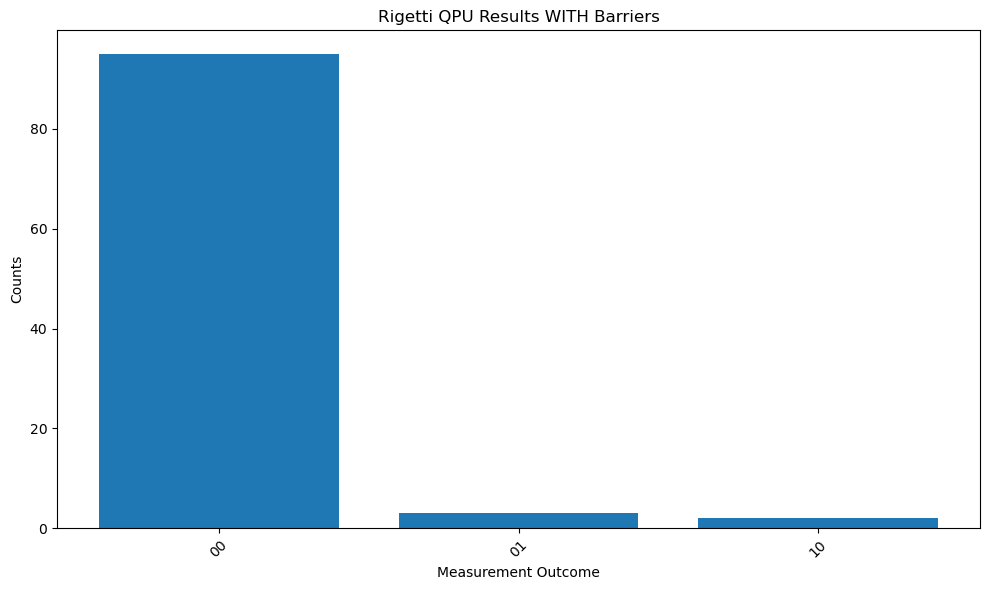

In [50]:
# Get results
rigetti_result = rigetti_task_with_barriers.result()
rigetti_counts = rigetti_result.measurement_counts

rigetti_counts_no_barriers = rigetti_task_no_barriers.result().measurement_counts

print("Measurement results from Rigetti QPU (WITH barriers):")
print(rigetti_counts)

# Plot the results
plt.figure(figsize=(10, 6))
plt.bar(rigetti_counts.keys(), rigetti_counts.values())
plt.xlabel('Measurement Outcome')
plt.ylabel('Counts')
plt.title('Rigetti QPU Results WITH Barriers')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Now, let's compare the above results with the circuit without barriers:

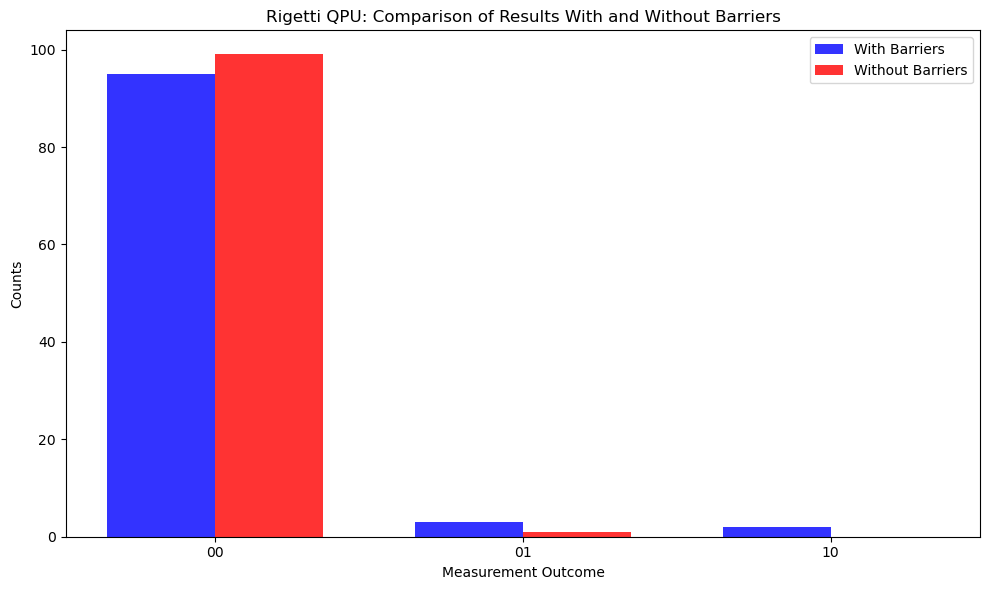


Note: Both circuits should return |00⟩ if executed perfectly.
Differences between the two are due to hardware noise and imperfections.


In [51]:
# Plot comparison on same graph
plt.figure(figsize=(10, 6))

# Get all unique measurement outcomes
all_outcomes = sorted(set(list(rigetti_counts.keys()) + list(rigetti_counts_no_barriers.keys())))

# Prepare data for plotting
x = range(len(all_outcomes))
width = 0.35

with_barriers = [rigetti_counts.get(outcome, 0) for outcome in all_outcomes]
without_barriers = [rigetti_counts_no_barriers.get(outcome, 0) for outcome in all_outcomes]

# Create bars
plt.bar([i - width/2 for i in x], with_barriers, width, label='With Barriers', alpha=0.8, color='blue')
plt.bar([i + width/2 for i in x], without_barriers, width, label='Without Barriers', alpha=0.8, color='red')

plt.xlabel('Measurement Outcome')
plt.ylabel('Counts')
plt.title('Rigetti QPU: Comparison of Results With and Without Barriers')
plt.xticks(x, all_outcomes)
plt.legend()
plt.tight_layout()
plt.show()

print("\nNote: Both circuits should return |00⟩ if executed perfectly.")
print("Differences between the two are due to hardware noise and imperfections.")

## Example 6: Running on IQM Garnet

Let's also demonstrate using barriers on the IQM Garnet quantum processor:

In [30]:
# Create a circuit for IQM Garnet device
# This circuit applies H-H and CNOT-CNOT sequences that would be optimized away
iqm_circuit = Circuit()

for _ in range(10):
    # Apply Hadamard gates
    iqm_circuit.h(0)
    iqm_circuit.h(1)

    # Barrier prevents optimization
    iqm_circuit.barrier([0, 1])

    # Apply CNOT
    iqm_circuit.cnot(0, 1)

    # Barrier prevents optimization
    iqm_circuit.barrier([0, 1])

    # Apply inverse CNOT (same as CNOT)
    iqm_circuit.cnot(0, 1)

    # Barrier prevents optimization
    iqm_circuit.barrier([0, 1])

    # Apply Hadamard gates again (H*H = I)
    iqm_circuit.h(0)
    iqm_circuit.h(1)

print("Circuit for IQM Garnet:")
print(iqm_circuit)
print()
print("Without barriers, this circuit would be optimized to identity:")
print("- H-H = I on both qubits")
print("- CNOT-CNOT = I")
print("With barriers, all gate layers are preserved and executed.")

Circuit for IQM Garnet:
T  : │  0  │  1   │  2  │  3   │  4  │  5   │  6  │  7  │  8   │  9  │  10  │ 11  │  12  │ 13  │ 14  │  15  │ 16  │  17  │ 18  │  19  │ 20  │ 21  │  22  │ 23  │  24  │ 25  │  26  │ 27  │ 28  │  29  │ 30  │  31  │ 32  │  33  │ 34  │ 35  │  36  │ 37  │  38  │ 39  │  40  │ 41  │ 42  │  43  │ 44  │  45  │ 46  │  47  │ 48  │ 49  │  50  │ 51  │  52  │ 53  │  54  │ 55  │ 56  │  57  │ 58  │  59  │ 60  │  61  │ 62  │ 63  │  64  │ 65  │  66  │ 67  │  68  │ 69  │
      ┌───┐                                  ┌───┐ ┌───┐                                  ┌───┐ ┌───┐                                  ┌───┐ ┌───┐                                  ┌───┐ ┌───┐                                  ┌───┐ ┌───┐                                  ┌───┐ ┌───┐                                  ┌───┐ ┌───┐                                  ┌───┐ ┌───┐                                  ┌───┐ ┌───┐                                  ┌───┐ 
q0 : ─┤ H ├───▒──────●─────▒──────●─────▒────┤ H ├─┤ H ├───▒──

In [ ]:
# Connect to IQM Garnet device
# Note: Replace with the appropriate IQM Garnet device ARN
iqm_device = AwsDevice("arn:aws:braket:eu-north-1::device/qpu/iqm/Garnet")

# Submit the task with barriers
iqm_task_with_barriers = iqm_device.run(iqm_circuit, shots=100)
print("Task submitted. Waiting for results...")

### Comparison: Same Circuit WITHOUT Barriers

Now let's run the same H-CNOT-CNOT-H circuit without barriers to see how the compiler optimizes it:

In [32]:
# Create the same circuit WITHOUT barriers
iqm_circuit_no_barrier = Circuit()

for _ in range(10):
    # Apply Hadamard gates
    iqm_circuit_no_barrier.h(0)
    iqm_circuit_no_barrier.h(1)

    # NO barrier - compiler can optimize

    # Apply CNOT
    iqm_circuit_no_barrier.cnot(0, 1)

    # NO barrier - compiler can optimize

    # Apply inverse CNOT
    iqm_circuit_no_barrier.cnot(0, 1)

    # NO barrier - compiler can optimize

    # Apply Hadamard gates again
    iqm_circuit_no_barrier.h(0)
    iqm_circuit_no_barrier.h(1)

print("Circuit WITHOUT barriers:")
print(iqm_circuit_no_barrier)
print()
print("The compiler will likely optimize this to identity:")
print("- H-H = I on both qubits")
print("- CNOT-CNOT = I")

Circuit WITHOUT barriers:
T  : │  0  │  1  │  2  │  3  │  4  │  5  │  6  │  7  │  8  │  9  │ 10  │ 11  │ 12  │ 13  │ 14  │ 15  │ 16  │ 17  │ 18  │ 19  │ 20  │ 21  │ 22  │ 23  │ 24  │ 25  │ 26  │ 27  │ 28  │ 29  │ 30  │ 31  │ 32  │ 33  │ 34  │ 35  │ 36  │ 37  │ 38  │ 39  │
      ┌───┐             ┌───┐ ┌───┐             ┌───┐ ┌───┐             ┌───┐ ┌───┐             ┌───┐ ┌───┐             ┌───┐ ┌───┐             ┌───┐ ┌───┐             ┌───┐ ┌───┐             ┌───┐ ┌───┐             ┌───┐ ┌───┐             ┌───┐ 
q0 : ─┤ H ├───●─────●───┤ H ├─┤ H ├───●─────●───┤ H ├─┤ H ├───●─────●───┤ H ├─┤ H ├───●─────●───┤ H ├─┤ H ├───●─────●───┤ H ├─┤ H ├───●─────●───┤ H ├─┤ H ├───●─────●───┤ H ├─┤ H ├───●─────●───┤ H ├─┤ H ├───●─────●───┤ H ├─┤ H ├───●─────●───┤ H ├─
      └───┘   │     │   └───┘ └───┘   │     │   └───┘ └───┘   │     │   └───┘ └───┘   │     │   └───┘ └───┘   │     │   └───┘ └───┘   │     │   └───┘ └───┘   │     │   └───┘ └───┘   │     │   └───┘ └───┘   │     │   └───┘ └───┘   │  

In [ ]:
# Submit the circuit without barriers
iqm_task_no_barriers = iqm_device.run(iqm_circuit_no_barrier, shots=100)
print("Task submitted. Waiting for results...")

### Inspecting the Compiled Circuits

Let's examine the actual compiled OpenQASM that was executed on IQM Garnet to see how the compiler handled barriers:

In [34]:
# Extract compiled circuits from task results
iqm_result_with_barriers = iqm_task_with_barriers.result()
iqm_result_no_barriers = iqm_task_no_barriers.result()

print("=" * 70)
print("COMPILED CIRCUITS - IQM GARNET")
print("=" * 70)

print("\n1. SUBMITTED CIRCUIT WITH BARRIERS:")
print("-" * 70)
print(iqm_result_with_barriers.additional_metadata.action.source)

print("\n2. COMPILED CIRCUIT WITH BARRIERS:")
print("-" * 70)
if hasattr(iqm_result_with_barriers.additional_metadata, 'iqmMetadata') and iqm_result_with_barriers.additional_metadata.iqmMetadata:
    print(iqm_result_with_barriers.additional_metadata.iqmMetadata.compiledProgram)
    print("\n✓ Barriers preserved in compiled circuit")
    print("✓ All gates present: H→CNOT→CNOT→H (as native prx and cz gates)")

print("\n3. SUBMITTED CIRCUIT WITHOUT BARRIERS:")
print("-" * 70)
print(iqm_result_no_barriers.additional_metadata.action.source)

print("\n4. COMPILED CIRCUIT WITHOUT BARRIERS:")
print("-" * 70)
if hasattr(iqm_result_no_barriers.additional_metadata, 'iqmMetadata') and iqm_result_no_barriers.additional_metadata.iqmMetadata:
    print(iqm_result_no_barriers.additional_metadata.iqmMetadata.compiledProgram)
    print("\n✓ Circuit optimized to identity (empty box {})")
    print("✓ All H-CNOT-CNOT-H gates removed by compiler")


COMPILED CIRCUITS - IQM GARNET

1. SUBMITTED CIRCUIT WITH BARRIERS:
----------------------------------------------------------------------
OPENQASM 3.0;
bit[2] b;
qubit[2] q;
h q[0];
h q[1];
barrier q[0], q[1];
cnot q[0], q[1];
barrier q[0], q[1];
cnot q[0], q[1];
barrier q[0], q[1];
h q[0];
h q[1];
h q[0];
h q[1];
barrier q[0], q[1];
cnot q[0], q[1];
barrier q[0], q[1];
cnot q[0], q[1];
barrier q[0], q[1];
h q[0];
h q[1];
h q[0];
h q[1];
barrier q[0], q[1];
cnot q[0], q[1];
barrier q[0], q[1];
cnot q[0], q[1];
barrier q[0], q[1];
h q[0];
h q[1];
h q[0];
h q[1];
barrier q[0], q[1];
cnot q[0], q[1];
barrier q[0], q[1];
cnot q[0], q[1];
barrier q[0], q[1];
h q[0];
h q[1];
h q[0];
h q[1];
barrier q[0], q[1];
cnot q[0], q[1];
barrier q[0], q[1];
cnot q[0], q[1];
barrier q[0], q[1];
h q[0];
h q[1];
h q[0];
h q[1];
barrier q[0], q[1];
cnot q[0], q[1];
barrier q[0], q[1];
cnot q[0], q[1];
barrier q[0], q[1];
h q[0];
h q[1];
h q[0];
h q[1];
barrier q[0], q[1];
cnot q[0], q[1];
barrier q[0], q[

KEY INSIGHT: Without barriers, the compiler recognized that H-CNOT-CNOT-H = Identity and optimized the entire circuit away!

### QHP Results

First, let's look at the QHP results for the circuit with barriers:

Measurement results from IQM Garnet (WITH barriers):
Counter({'00': 69, '10': 18, '01': 7, '11': 6})


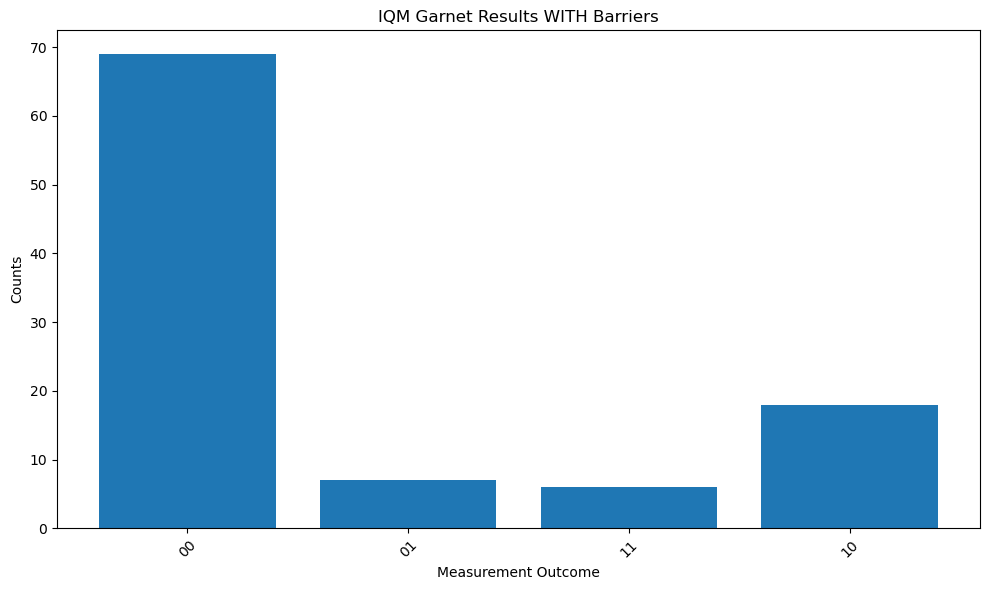

In [36]:
# Get results
iqm_result = iqm_task_with_barriers.result()
iqm_counts = iqm_result.measurement_counts

iqm_counts_no_barriers = iqm_task_no_barriers.result().measurement_counts

print("Measurement results from IQM Garnet (WITH barriers):")
print(iqm_counts)

# Plot the results
plt.figure(figsize=(10, 6))
plt.bar(iqm_counts.keys(), iqm_counts.values())
plt.xlabel('Measurement Outcome')
plt.ylabel('Counts')
plt.title('IQM Garnet Results WITH Barriers')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Now, let's compare the above results with the circuit without barriers:

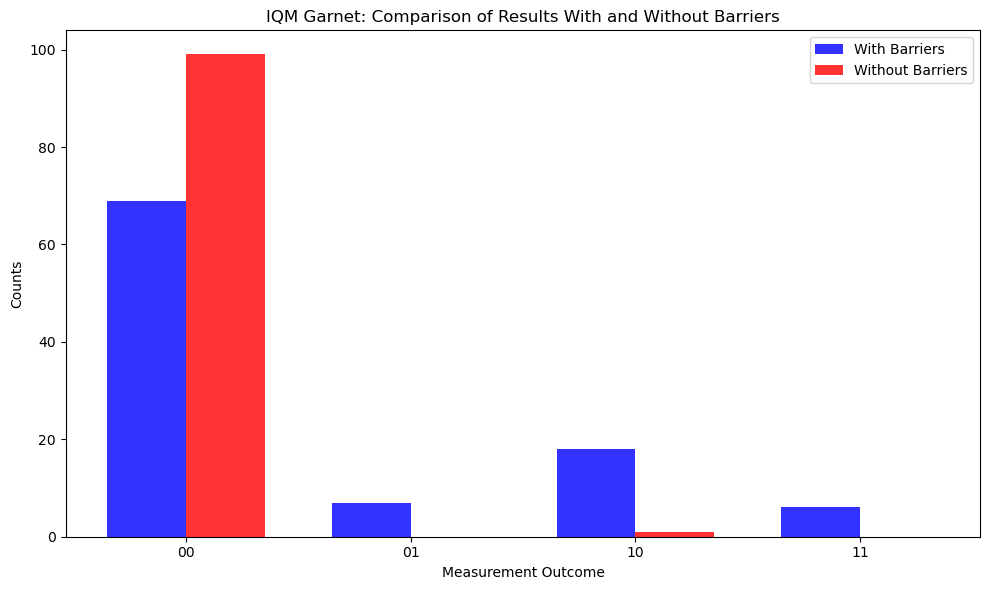


The compiled circuits show that:
- WITH barriers: Gates are preserved in the compiled output
- WITHOUT barriers: Circuit is optimized (gates may be removed or reordered)


In [38]:
# Plot comparison on same graph
plt.figure(figsize=(10, 6))

# Get all unique measurement outcomes
all_outcomes = sorted(set(list(iqm_counts.keys()) + list(iqm_counts_no_barriers.keys())))

# Prepare data for plotting
x = range(len(all_outcomes))
width = 0.35

with_barriers = [iqm_counts.get(outcome, 0) for outcome in all_outcomes]
without_barriers = [iqm_counts_no_barriers.get(outcome, 0) for outcome in all_outcomes]

# Create bars
plt.bar([i - width/2 for i in x], with_barriers, width, label='With Barriers', alpha=0.8, color='blue')
plt.bar([i + width/2 for i in x], without_barriers, width, label='Without Barriers', alpha=0.8, color='red')

plt.xlabel('Measurement Outcome')
plt.ylabel('Counts')
plt.title('IQM Garnet: Comparison of Results With and Without Barriers')
plt.xticks(x, all_outcomes)
plt.legend()
plt.tight_layout()
plt.show()

print("\nThe compiled circuits show that:")
print("- WITH barriers: Gates are preserved in the compiled output")
print("- WITHOUT barriers: Circuit is optimized (gates may be removed or reordered)")

## Example 7: Practical Use Case - Mirror Benchmarking

Mirror benchmarking is a technique for characterizing quantum devices by running a circuit followed by its inverse. Barriers are crucial here to ensure the compiler doesn't optimize away the mirror structure. The circuit should ideally return to the initial state |00...0⟩.

In [39]:
import numpy as np


def create_mirror_benchmark_circuit(depth=7):
    """
    Create a mirror benchmarking circuit with barriers.
    
    The circuit applies a sequence of gates, then applies their inverse
    in reverse order. Barriers prevent the compiler from optimizing
    away the mirror structure.
    
    Args:
        depth: Number of gate layers in the forward pass
    
    Returns:
        Circuit with forward and mirror sections separated by barriers
    """
    circuit = Circuit()
    
    # Store the forward operations to mirror them later
    forward_ops = []
    
    # Forward pass: Apply random gates
    for layer in range(depth):
        # Single-qubit rotations
        angle1 = np.pi / 4 * (layer + 1)
        angle2 = np.pi / 3 * (layer + 1)
        
        circuit.rx(0, angle1)
        circuit.ry(1, angle2)
        forward_ops.append(('rx', 0, angle1))
        forward_ops.append(('ry', 1, angle2))
        
        # Entangling gate
        circuit.cnot(0, 1)
        forward_ops.append(('cnot', 0, 1))
        
        # Barrier after each layer
        circuit.barrier([0, 1])
    
    # Critical barrier separating forward and mirror sections
    circuit.barrier([0, 1])
    
    # Mirror pass: Apply inverse operations in reverse order
    for op in reversed(forward_ops):
        if op[0] == 'cnot':
            circuit.cnot(op[1], op[2])
        elif op[0] == 'rx':
            circuit.rx(op[1], -op[2])  # Inverse rotation
        elif op[0] == 'ry':
            circuit.ry(op[1], -op[2])  # Inverse rotation
    
    # Final barrier before measurement
    circuit.barrier([0, 1])
    
    return circuit

# Create mirror benchmark circuit
mirror_circuit = create_mirror_benchmark_circuit(depth=10)

print("Mirror Benchmarking Circuit:")
print(mirror_circuit)
print()
print("This circuit should return to |00⟩ if executed perfectly.")
print("Deviations from |00⟩ indicate noise and errors in the quantum device.")

Mirror Benchmarking Circuit:
T  : │     0      │  1  │  2   │     3      │  4  │  5   │     6      │  7  │  8   │     9      │ 10  │  11  │     12     │ 13  │  14  │     15     │ 16  │  17  │     18     │ 19  │  20  │     21     │ 22  │  23  │     24     │ 25  │  26  │     27      │ 28  │  29  │  30  │ 31  │      32      │ 33  │     34      │ 35  │     36      │ 37  │     38      │ 39  │     40      │ 41  │     42      │ 43  │     44      │ 45  │     46      │ 47  │     48      │ 49  │     50      │  51  │
      ┌──────────┐              ┌──────────┐              ┌──────────┐              ┌──────────┐              ┌──────────┐              ┌──────────┐              ┌──────────┐              ┌──────────┐              ┌──────────┐              ┌──────────┐                            ┌───────────┐        ┌───────────┐       ┌───────────┐       ┌───────────┐       ┌───────────┐       ┌───────────┐       ┌───────────┐       ┌───────────┐       ┌───────────┐       ┌───────────┐        
q0 : 


Mirror circuit results on ideal simulator:
Counter({'00': 1000})

Probability of returning to |00⟩: 100.0%


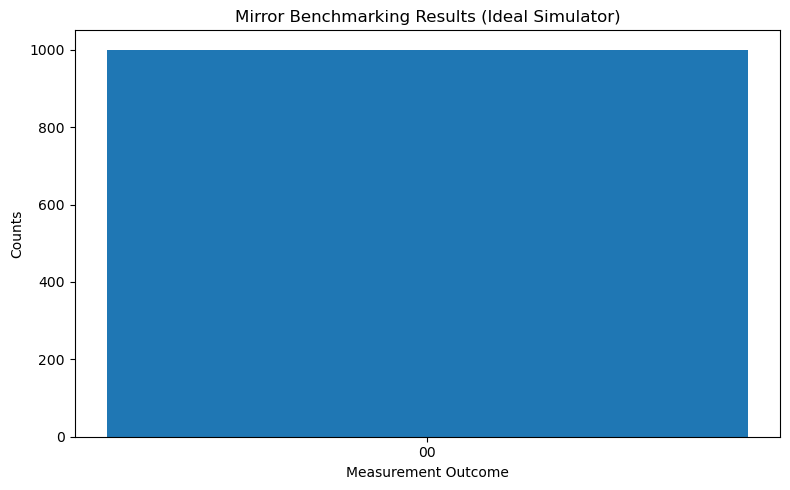


Note: On a real QPU, you would see deviations from |00⟩ due to gate errors and decoherence.
The fidelity (probability of |00⟩) decreases with circuit depth, providing a benchmark metric.


In [40]:
# Run the mirror circuit on a local simulator to verify it returns to |00⟩
from braket.devices import LocalSimulator

local_sim = LocalSimulator()
mirror_task = local_sim.run(mirror_circuit, shots=1000)
mirror_result = mirror_task.result()
mirror_counts = mirror_result.measurement_counts

print("\nMirror circuit results on ideal simulator:")
print(mirror_counts)
print(f"\nProbability of returning to |00⟩: {mirror_counts.get('00', 0) / 1000:.1%}")

# Plot the results
plt.figure(figsize=(8, 5))
plt.bar(mirror_counts.keys(), mirror_counts.values())
plt.xlabel('Measurement Outcome')
plt.ylabel('Counts')
plt.title('Mirror Benchmarking Results (Ideal Simulator)')
plt.tight_layout()
plt.show()

print("\nNote: On a real QPU, you would see deviations from |00⟩ due to gate errors and decoherence.")
print("The fidelity (probability of |00⟩) decreases with circuit depth, providing a benchmark metric.")

### Running Mirror Benchmarking on IQM Garnet

Now let's run the same mirror benchmarking circuit on real quantum hardware (IQM Garnet) and compare the results with the ideal simulator. This will demonstrate how barriers preserve the circuit structure on actual devices and allow us to measure the fidelity degradation due to real hardware noise.

In [ ]:
# Run on IQM Garnet device
iqm_device = AwsDevice("arn:aws:braket:eu-north-1::device/qpu/iqm/Garnet")

# Submit the mirror benchmarking circuit
mirror_task_iqm = iqm_device.run(mirror_circuit, shots=1000)
print("Task submitted. Waiting for results...")

Mirror circuit results on IQM Garnet:
Counter({'00': 668, '11': 145, '01': 112, '10': 75})

Probability of returning to |00⟩: 66.8%

=== Fidelity Comparison ===
Ideal Simulator: 100.0%
IQM Garnet:      66.8%
Fidelity Loss:   33.2 percentage points


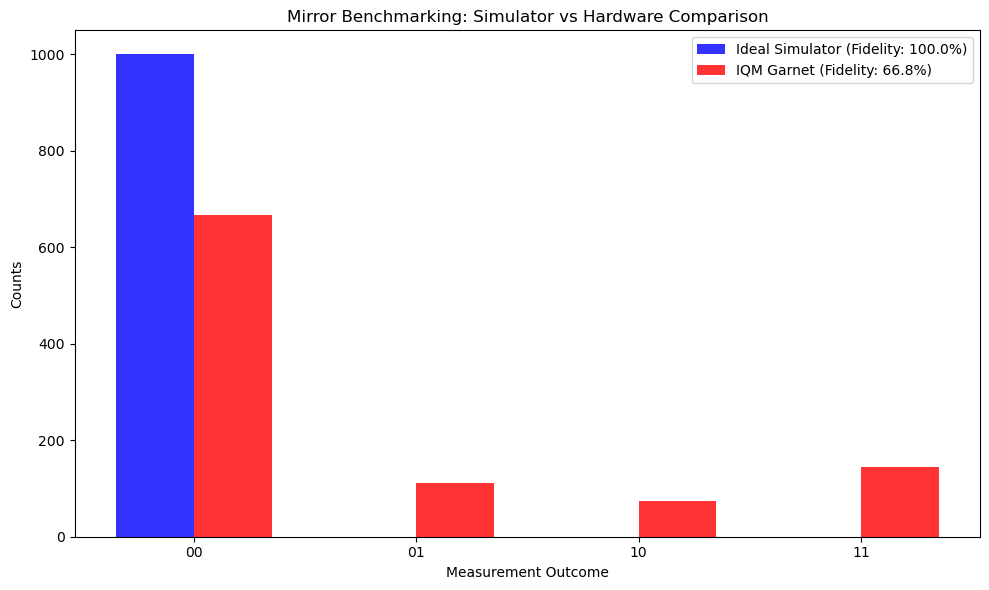


The difference in fidelity demonstrates the impact of gate errors and decoherence on real hardware.
Barriers ensure that the full mirror structure is executed, allowing accurate benchmarking.


In [42]:
# Get results from IQM Garnet
mirror_result_iqm = mirror_task_iqm.result()
mirror_counts_iqm = mirror_result_iqm.measurement_counts

print("Mirror circuit results on IQM Garnet:")
print(mirror_counts_iqm)
print(f"\nProbability of returning to |00⟩: {mirror_counts_iqm.get('00', 0) / 1000:.1%}")

# Compare with simulator results
sim_fidelity = mirror_counts.get('00', 0) / 1000
hardware_fidelity = mirror_counts_iqm.get('00', 0) / 1000
fidelity_loss = (sim_fidelity - hardware_fidelity) * 100

print("\n=== Fidelity Comparison ===")
print(f"Ideal Simulator: {sim_fidelity:.1%}")
print(f"IQM Garnet:      {hardware_fidelity:.1%}")
print(f"Fidelity Loss:   {fidelity_loss:.1f} percentage points")

# Plot comparison on same graph
plt.figure(figsize=(10, 6))

# Get all unique measurement outcomes
all_outcomes = sorted(set(list(mirror_counts.keys()) + list(mirror_counts_iqm.keys())))

# Prepare data for plotting
x = range(len(all_outcomes))
width = 0.35

sim_values = [mirror_counts.get(outcome, 0) for outcome in all_outcomes]
hardware_values = [mirror_counts_iqm.get(outcome, 0) for outcome in all_outcomes]

# Create bars
plt.bar([i - width/2 for i in x], sim_values, width, 
        label=f'Ideal Simulator (Fidelity: {sim_fidelity:.1%})', alpha=0.8, color='blue')
plt.bar([i + width/2 for i in x], hardware_values, width, 
        label=f'IQM Garnet (Fidelity: {hardware_fidelity:.1%})', alpha=0.8, color='red')

plt.xlabel('Measurement Outcome')
plt.ylabel('Counts')
plt.title('Mirror Benchmarking: Simulator vs Hardware Comparison')
plt.xticks(x, all_outcomes)
plt.legend()
plt.tight_layout()
plt.show()

print("\nThe difference in fidelity demonstrates the impact of gate errors and decoherence on real hardware.")
print("Barriers ensure that the full mirror structure is executed, allowing accurate benchmarking.")

## Example 8: Partial Barriers in Multi-Qubit Circuits

Barriers can be applied to specific subsets of qubits rather than all qubits. This gives fine-grained control over which operations can be reordered by the compiler. Partial barriers are useful when you want to preserve the order of operations on some qubits while allowing optimization on others.

In [43]:
# Create a 4-qubit circuit with partial barriers
multi_qubit_circuit = Circuit()

# Initialization phase
for i in range(4):
    multi_qubit_circuit.h(i)

# Partial barrier only on qubits 0 and 1
# This prevents optimization across the barrier for qubits 0 and 1,
# but allows optimization on qubits 2 and 3
multi_qubit_circuit.barrier([0, 1])

# First entangling layer
multi_qubit_circuit.cnot(0, 1)
multi_qubit_circuit.cnot(2, 3)

# Partial barrier on qubits 1 and 2
# This creates a barrier between the two CNOT pairs
multi_qubit_circuit.barrier([1, 2])

# Second entangling layer
multi_qubit_circuit.cnot(1, 2)

# Partial barrier on qubits 2 and 3
multi_qubit_circuit.barrier([2, 3])

# Single-qubit rotations
for i in range(4):
    multi_qubit_circuit.rz(i, 0.5)

print("Multi-qubit circuit with partial barriers:")
print(multi_qubit_circuit)
print()
print("Note: The barriers (▒) appear only on the specified qubits.")
print("Operations on other qubits can still be optimized across these barriers.")

Multi-qubit circuit with partial barriers:
T  : │  0  │  1   │  2  │     3      │  4  │     5      │     6      │
      ┌───┐              ┌──────────┐                                 
q0 : ─┤ H ├───▒──────●───┤ Rz(0.50) ├─────────────────────────────────
      └───┘          │   └──────────┘                                 
      ┌───┐        ┌─┴─┐                    ┌──────────┐              
q1 : ─┤ H ├───▒────┤ X ├──────▒─────────●───┤ Rz(0.50) ├──────────────
      └───┘        └───┘                │   └──────────┘              
      ┌───┐                           ┌─┴─┐              ┌──────────┐ 
q2 : ─┤ H ├───●───────────────▒───────┤ X ├──────▒───────┤ Rz(0.50) ├─
      └───┘   │                       └───┘              └──────────┘ 
      ┌───┐ ┌─┴─┐                                        ┌──────────┐ 
q3 : ─┤ H ├─┤ X ├────────────────────────────────▒───────┤ Rz(0.50) ├─
      └───┘ └───┘                                        └──────────┘ 
T  : │  0  │  1   │  2  │     3   

## Checking Device Support for Barriers

Before using barriers, you can check if a device supports them by examining the device properties:

In [44]:
# Check if Rigetti device supports barriers
rigetti_device = AwsDevice("arn:aws:braket:us-west-1::device/qpu/rigetti/Ankaa-3")

# Check supported operations in OpenQASM
if "braket.ir.openqasm.program" in rigetti_device.properties.action:
    openqasm_props = rigetti_device.properties.action["braket.ir.openqasm.program"]
    
    print("Rigetti Device OpenQASM Support:")
    print(f"Supported operations: {sorted(openqasm_props.supportedOperations)}...")
    
    # Check if barrier is in supported operations
    if "barrier" in openqasm_props.supportedOperations:
        print("✓ Barrier statement is supported!")
    else:
        print("✗ Barrier statement is not supported")
else:
    print("OpenQASM support information not available")

Rigetti Device OpenQASM Support:
Supported operations: ['barrier', 'ccnot', 'cnot', 'cphaseshift', 'cphaseshift00', 'cphaseshift01', 'cphaseshift10', 'cswap', 'cz', 'h', 'i', 'iswap', 'phaseshift', 'pswap', 'rx', 'ry', 'rz', 's', 'si', 'swap', 't', 'ti', 'x', 'xy', 'y', 'z']...
✓ Barrier statement is supported!


## Best Practices for Using Barriers

### When to use barriers:

1. **Debugging**: When you need to understand exactly what gates are being executed
2. **Benchmarking**: To ensure benchmarking circuits aren't optimized away due to redundancies (e.g., mirror circuits, randomized benchmarking)
3. **Algorithm structure**: To maintain logical phases (initialization, computation, measurement)
4. **Preventing optimization**: When compiler optimization might change intended behavior

### Tips:

- Use barriers sparingly - they prevent beneficial optimizations
- Apply barriers to specific qubits when possible, rather than all qubits
- Document why you're using barriers in your code
- Test both with and without barriers to understand the impact

## Summary

In this notebook, we've explored the OpenQASM 3 `barrier` statement on Amazon Braket:

- **What barriers do**: Prevent compiler optimization across barrier boundaries
- **How to use them**: Both in OpenQASM programs and with the Braket SDK
- **Device support**: Barriers are supported on Rigetti and IQM Garnet QPUs
- **Practical examples**: From simple Bell states to mirror benchmarking circuits
- **Best practices**: When to use barriers and when to avoid them

The barrier statement is a powerful tool for controlling circuit compilation and preserving the structure of your quantum algorithms. Use it wisely to balance between maintaining intended circuit structure and allowing beneficial compiler optimizations.

In [ ]:
print("Quantum Task Summary")
print(t.quantum_tasks_statistics())
print(
    "Note: Charges shown are estimates based on your Amazon Braket simulator and quantum processing unit (QPU) task usage. Estimated charges shown may differ from your actual charges. Estimated charges do not factor in any discounts or credits, and you may experience additional charges based on your use of other services such as Amazon Elastic Compute Cloud (Amazon EC2).",
)
print(
    f"Estimated cost to run this example: {t.qpu_tasks_cost() + t.simulator_tasks_cost():.3f} USD",
)